In [1]:
#pip install sympy
#pip install numpy
#pip install pandas
#pip install matplotlib

In [2]:
import numpy as np
from sympy import symbols, Eq, solve
from sympy.interactive import printing
from sympy import pi
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from src import CryoTOCS

## Calibration

### Import data

In [4]:
path='test\Messung051224\GreaseDataVacuum1.txt'

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\rinc\AppData\Local\Temp\ipykernel_22144\683402596.py:1: SyntaxWarning: invalid escape sequence '\M'
  path='test\Messung051224\GreaseDataVacuum1.txt'


In [5]:
df = CryoTOCS.import_Data(path)
df.head()

,Frequency,Re(1ω),Im(1ω),Re(3ω),Im(3ω),Phase(1ω),Phase(3ω),Vref,Current,Re(ΔT),Δ[Re(ΔT)],Im(ΔT),Δ[Im(ΔT)],Power,Temperature
0,10.000,0.184437030678751,0.000000000000000,0.000260408972433,-0.000065735910170,0.000000000000056,-14.167387803957695,0.052110,0.005211,0.824032,0.000000,-0.208013,0.009426,0.000961,27.28
1,12.743,0.184472240125837,-0.000000000000002,0.000250413696423,-0.000065420904660,-0.000000000000486,-14.641350469289304,0.052121,0.005212,0.792244,0.000000,-0.206975,0.009379,0.000961,27.28
2,16.238,0.184501818686206,0.000000000000003,0.000240364494020,-0.000065107642367,0.000000000000918,-15.156050153835725,0.052124,0.005212,0.760411,0.000000,-0.205973,0.009333,0.000962,27.31
3,20.691,0.184498163976574,-0.000000000000004,0.000230400186952,-0.000064640280522,-0.000000000001258,-15.671811641969777,0.052125,0.005212,0.728871,0.000000,-0.204490,0.009266,0.000962,27.30
4,26.367,0.184483429107614,-0.000000000000009,0.000220346733487,-0.000064252819370,-0.000000000002679,-16.256615346477268,0.052123,0.005212,0.697096,0.000000,-0.203272,0.009211,0.000962,27.29


In [6]:
# LaTeX rendering
printing.init_printing()

In [7]:
# Define variables
dRdT = symbols('dR/dT')
dVdf= symbols('dV3w/dlnf')
dR,dT,L,lambda_sub,lambda_s,f,P,I = symbols('dR dT L lambda_sub lambda_s f P I')

In [8]:
equation_dRdT = Eq( ((-4*pi*L)/(P*I))*(lambda_sub+lambda_s)*(dVdf)- dRdT,0)

In [9]:
display(equation_dRdT)

### Parameter fuer die Berechnung

In [10]:
# Geometrie und Bedingungen
T_ref=26           # Room temperature, 24 04.12.24
lambdaGrease_mess= 0.2 #Datasheet

# Slope dRe(V3w)/dlnf Berechnung
v3w=df['Re(3ω)'].values
f=df['Frequency'].values
v3w=v3w.astype(float)
f=f.astype(float)

## dRdT Berechnung

L_mess=1500e-6
P_mess= df['Power'].values
P_mess=P_mess.astype(float)

I_mess= df['Current'].values
I_mess=I_mess.astype(float)

### Substrate thermal conductivity

In [11]:
lambdaSubstrate_mess=CryoTOCS.lambdaSubstrate(T_ref)
lambdaSubstrate_mess

### Slope dRe(V3w)/dln(f)

In [12]:
lnf=np.log(f)
print(v3w)
print(f)
print(lnf)

[2.60408972e-04 2.50413696e-04 2.40364494e-04 2.30400187e-04
 2.20346733e-04 2.10358465e-04 2.00464730e-04 1.90646474e-04
 1.80890595e-04 1.71116221e-04 1.61477506e-04 1.51907959e-04
 1.42492229e-04 1.33228677e-04 1.24008072e-04 1.15060106e-04
 1.06364306e-04 9.79663101e-05 8.96253227e-05 8.31308461e-05]
[  10.      12.743   16.238   20.691   26.367   33.598   42.813   54.556
   69.519   88.587  112.884  143.845  183.298  233.572  297.635  379.269
  483.293  615.848  784.76  1000.   ]
[2.30258509 2.5449821  2.78735417 3.02969882 3.27211323 3.51446654
 3.75684179 3.9992277  4.2416001  4.48398512 4.72636074 4.96873633
 5.21111324 5.45349038 5.6958679  5.93824572 6.18062309 6.42300018
 6.66537794 6.90775528]


Slope: -3.906621169740782e-05, Intercept: 0.0003479401910728244


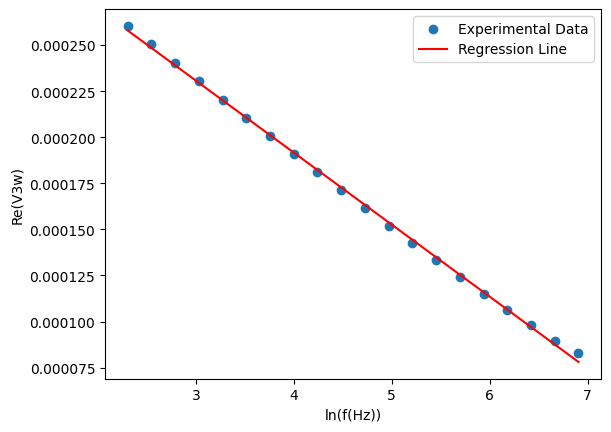

In [13]:
dVdf_mess=CryoTOCS.fit_dVdf(lnf,v3w)

In [14]:
dVdf_mess

### dR/dT Berechnung

In [15]:
P_mean= np.mean(P_mess)
I_mean= np.mean(I_mess)
print(P_mean)
print(I_mean)
print(lambdaSubstrate_mess)

0.0009617500000000001
0.005212649999999999
3.0078


In [16]:
substituted_eq = equation_dRdT.subs({P: P_mean, I:I_mean, lambda_sub:lambdaSubstrate_mess,lambda_s: lambdaGrease_mess,dVdf:dVdf_mess, L:L_mess})

In [17]:
substituted_eq

In [18]:
sol = solve(substituted_eq, dRdT)

In [19]:
dRdT_mess=float(sol[0])
dRdT_mess

## Messung Thermal conductivity mit gleicher Probe unter Vacuum

### Import data

In [20]:
path_sample='test\Messung051224\GreaseDataVacuum1.txt'

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\rinc\AppData\Local\Temp\ipykernel_22144\4249350543.py:1: SyntaxWarning: invalid escape sequence '\M'
  path_sample='test\Messung051224\GreaseDataVacuum1.txt'


In [21]:
df_sample=CryoTOCS.import_Data(path_sample)
df_sample.head()

,Frequency,Re(1ω),Im(1ω),Re(3ω),Im(3ω),Phase(1ω),Phase(3ω),Vref,Current,Re(ΔT),Δ[Re(ΔT)],Im(ΔT),Δ[Im(ΔT)],Power,Temperature
0,10.000,0.184437030678751,0.000000000000000,0.000260408972433,-0.000065735910170,0.000000000000056,-14.167387803957695,0.052110,0.005211,0.824032,0.000000,-0.208013,0.009426,0.000961,27.28
1,12.743,0.184472240125837,-0.000000000000002,0.000250413696423,-0.000065420904660,-0.000000000000486,-14.641350469289304,0.052121,0.005212,0.792244,0.000000,-0.206975,0.009379,0.000961,27.28
2,16.238,0.184501818686206,0.000000000000003,0.000240364494020,-0.000065107642367,0.000000000000918,-15.156050153835725,0.052124,0.005212,0.760411,0.000000,-0.205973,0.009333,0.000962,27.31
3,20.691,0.184498163976574,-0.000000000000004,0.000230400186952,-0.000064640280522,-0.000000000001258,-15.671811641969777,0.052125,0.005212,0.728871,0.000000,-0.204490,0.009266,0.000962,27.30
4,26.367,0.184483429107614,-0.000000000000009,0.000220346733487,-0.000064252819370,-0.000000000002679,-16.256615346477268,0.052123,0.005212,0.697096,0.000000,-0.203272,0.009211,0.000962,27.29


### Parameters fuer die Berechnung

In [22]:
# Geometrie und Bedingungen
T_ref=26                 # Room temperature
print(dRdT_mess)

# Slope dRe(V3w)/dlnf Berechnung
v3w = df_sample['Re(3ω)'].values
f   = df_sample['Frequency'].values
v3w = v3w.astype(float)
f   = f.astype(float)

## Thermal conductivity Berechnung
P_mess = df_sample['Power'].values
P_mess = P_mess.astype(float)

I_mess = df_sample['Current'].values
I_mess = I_mess.astype(float)

0.4711822750888865


In [23]:
lambdaSubstrate_mess=CryoTOCS.lambdaSubstrate(T_ref)
lambdaSubstrate_mess

### Slope dRe(V3w)/dln(f)

In [24]:
lnf=np.log(f)
print(v3w)
print(f)
print(lnf)

[2.60408972e-04 2.50413696e-04 2.40364494e-04 2.30400187e-04
 2.20346733e-04 2.10358465e-04 2.00464730e-04 1.90646474e-04
 1.80890595e-04 1.71116221e-04 1.61477506e-04 1.51907959e-04
 1.42492229e-04 1.33228677e-04 1.24008072e-04 1.15060106e-04
 1.06364306e-04 9.79663101e-05 8.96253227e-05 8.31308461e-05]
[  10.      12.743   16.238   20.691   26.367   33.598   42.813   54.556
   69.519   88.587  112.884  143.845  183.298  233.572  297.635  379.269
  483.293  615.848  784.76  1000.   ]
[2.30258509 2.5449821  2.78735417 3.02969882 3.27211323 3.51446654
 3.75684179 3.9992277  4.2416001  4.48398512 4.72636074 4.96873633
 5.21111324 5.45349038 5.6958679  5.93824572 6.18062309 6.42300018
 6.66537794 6.90775528]


Slope: -3.906621169740782e-05, Intercept: 0.0003479401910728244


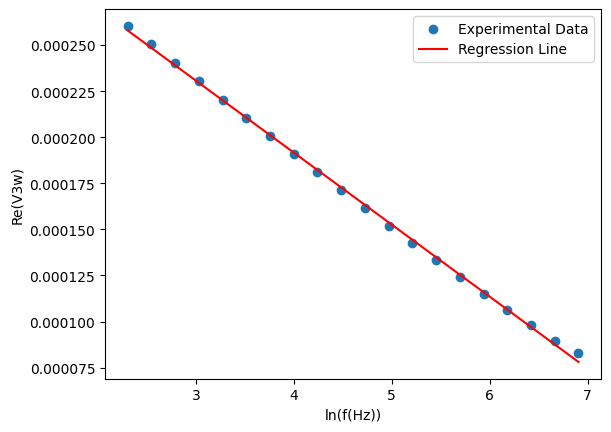

In [25]:
dVdf_mess=CryoTOCS.fit_dVdf(lnf,v3w)

In [26]:
dVdf_mess

### Thermal conductivity der Probe Berechnung

#### Korrelationsgleichung fuer die Messung

In [27]:
# Define variables
dRdT = symbols('dR/dT')
dVdf= symbols('dV3w/dlnf')
dR,dT,L,lambda_sample,lambda_sub,f,P,I = symbols('dR dT L lambda_sample, lambda_sub f P I')

In [28]:
equation_lambdaSample= Eq( (-P*I*dRdT/(4*pi*L))*(dVdf)**(-1)-lambda_sub-lambda_sample,0)

In [29]:
display(equation_lambdaSample)

In [30]:
P_mean= np.mean(P_mess)
I_mean= np.mean(I_mess)
print(P_mean)
print(I_mean)
print(lambdaSubstrate_mess)
print(dRdT_mess)

0.0009617500000000001
0.005212649999999999
3.0078
0.4711822750888865


In [31]:
substituted_eqLambdaSample = equation_lambdaSample.subs({dRdT:dRdT_mess,P: P_mean, I:I_mean, lambda_sub:lambdaSubstrate_mess,dVdf:dVdf_mess, L:L_mess})

In [32]:
substituted_eqLambdaSample

In [33]:
solSample = solve(substituted_eqLambdaSample, lambda_sample)

In [34]:
lambdaSample_mess=float(solSample[0])
lambdaSample_mess

## Messung des Substrats unter Vacuum

### Import data

In [35]:
path_sample='test\calibrationdataVacuum.txt'

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\rinc\AppData\Local\Temp\ipykernel_22144\2045195073.py:1: SyntaxWarning: invalid escape sequence '\c'
  path_sample='test\calibrationdataVacuum.txt'


In [36]:
df_sample=CryoTOCS.import_Data(path_sample)
df_sample.head()

,Frequency,Re(1ω),Im(1ω),Re(3ω),Im(3ω),Phase(1ω),Phase(3ω),Vref,Current,Re(ΔT),Δ[Re(ΔT)],Im(ΔT),Δ[Im(ΔT)],Power,Temperature
0,10.000,0.188154722112770,0.000000000000004,0.000302510967874,-0.000070525753694,0.000000000001129,-13.123219620804100,0.053454,0.005345,0.956597,0.000000,-0.223016,0.010092,0.001006,26.72
1,12.743,0.188162819633189,-0.000000000000003,0.000291282705193,-0.000071742393931,-0.000000000000896,-13.836446827147803,0.053459,0.005346,0.920999,0.000000,-0.226840,0.010265,0.001006,26.71
2,16.238,0.188168867443238,-0.000000000000007,0.000280038424339,-0.000071814876823,-0.000000000002086,-14.383343655170263,0.053461,0.005346,0.885413,0.000000,-0.227061,0.010275,0.001006,26.71
3,20.691,0.188169867695215,0.000000000000001,0.000269073677081,-0.000071116173245,0.000000000000325,-14.804745304785998,0.053465,0.005347,0.850680,0.000000,-0.224835,0.010174,0.001006,26.68
4,26.367,0.188170050381801,0.000000000000004,0.000257984198735,-0.000071068510128,0.000000000001184,-15.401614811542522,0.053469,0.005347,0.815572,0.000000,-0.224671,0.010167,0.001006,26.67


### Parameters fuer die Berechnung

In [37]:
# Geometrie und Bedingungen
T_ref=23                 # Room temperature
print(dRdT_mess)

# Slope dRe(V3w)/dlnf Berechnung
v3w = df_sample['Re(3ω)'].values
f   = df_sample['Frequency'].values
v3w = v3w.astype(float)
f   = f.astype(float)

## Thermal conductivity Berechnung
P_mess = df_sample['Power'].values
P_mess = P_mess.astype(float)

I_mess = df_sample['Current'].values
I_mess = I_mess.astype(float)

0.4711822750888865


### Slope dRe(V3w)/dln(f)

In [38]:
lnf=np.log(f)
print(v3w)
print(f)
print(lnf)

[0.00030251 0.00029128 0.00028004 0.00026907 0.00025798 0.00024693
 0.00023595 0.00022508 0.00021407 0.00020334 0.00019228 0.00018133
 0.00017091 0.00016004 0.0001497  0.00013921 0.00012922 0.000119
 0.00010925 0.00010145]
[  10.      12.743   16.238   20.691   26.367   33.598   42.813   54.556
   69.519   88.587  112.884  143.845  183.298  233.572  297.635  379.269
  483.293  615.848  784.76  1000.   ]
[2.30258509 2.5449821  2.78735417 3.02969882 3.27211323 3.51446654
 3.75684179 3.9992277  4.2416001  4.48398512 4.72636074 4.96873633
 5.21111324 5.45349038 5.6958679  5.93824572 6.18062309 6.42300018
 6.66537794 6.90775528]


Slope: -4.417865266570014e-05, Intercept: 0.0004023822864243119


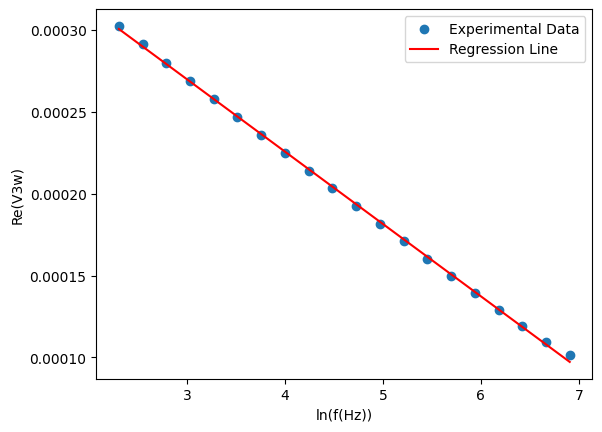

In [39]:
dVdf_mess=CryoTOCS.fit_dVdf(lnf,v3w)

In [40]:
dVdf_mess

### Thermal conductivity der Probe Berechnung

#### Korrelationsgleichung fuer die Messung

In [41]:
# Define variables
dRdT = symbols('dR/dT')
dVdf= symbols('dV3w/dlnf')
dR,dT,L,lambda_sample,lambda_sub,f,P,I = symbols('dR dT L lambda_sample, lambda_sub f P I')

In [42]:
equation_lambdaSample= Eq( (-P*I*dRdT/(4*pi*L))*(dVdf)**(-1)-lambda_sub,0)

In [43]:
display(equation_lambdaSample)

In [44]:
P_mean= np.mean(P_mess)
I_mean= np.mean(I_mess)
print(P_mean)
print(I_mean)
print(lambdaSubstrate_mess)
print(dRdT_mess)

0.001006
0.005348199999999999
3.0078
0.4711822750888865


In [45]:
substituted_eqLambdaSample = equation_lambdaSample.subs({dRdT:dRdT_mess,P: P_mean, I:I_mean,dVdf:dVdf_mess, L:L_mess})

In [46]:
substituted_eqLambdaSample

In [47]:
solSample = solve(substituted_eqLambdaSample, lambda_sub)

In [48]:
lambdaSample_mess=float(solSample[0])
lambdaSample_mess

In [49]:
CryoTOCS.lambdaSubstrate(T_ref)

## Messung Thermal conductivity Air

### Import data

In [50]:
path_sample='test\Messung061224\AirData1.txt'

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\rinc\AppData\Local\Temp\ipykernel_22144\4160392252.py:1: SyntaxWarning: invalid escape sequence '\M'
  path_sample='test\Messung061224\AirData1.txt'


In [51]:
df_sample=CryoTOCS.import_Data(path_sample)
df_sample.head()

,Frequency,Re(1ω),Im(1ω),Re(3ω),Im(3ω),Phase(1ω),Phase(3ω),Vref,Current,Re(ΔT),Δ[Re(ΔT)],Im(ΔT),Δ[Im(ΔT)],Power,Temperature
0,10.000,0.187305969200257,-0.000000000000006,0.000305022495720,-0.000072116328212,-0.000000000001740,-13.302146458317843,0.053628,0.005363,0.937893,0.000000,-0.221746,0.010047,0.001004,23.43
1,12.743,0.187299580227762,-0.000000000000003,0.000293896006287,-0.000071912143013,-0.000000000000968,-13.749309823498775,0.053628,0.005363,0.903677,0.000000,-0.221117,0.010018,0.001004,23.42
2,16.238,0.187296059096597,0.000000000000011,0.000282637043949,-0.000071902963395,0.000000000003376,-14.273287585759025,0.053628,0.005363,0.869067,0.000000,-0.221091,0.010017,0.001004,23.42
3,20.691,0.187288598654110,-0.000000000000002,0.000271556187969,-0.000071516974791,-0.000000000000699,-14.754379685577380,0.053628,0.005363,0.834986,0.000000,-0.219902,0.009963,0.001004,23.41
4,26.367,0.187276922672467,0.000000000000003,0.000260540673452,-0.000071687074235,0.000000000000782,-15.384099575292471,0.053630,0.005363,0.801087,0.000000,-0.220417,0.009987,0.001004,23.38


### Parameters fuer die Berechnung

In [52]:
# Geometrie und Bedingungen
T_ref=23                 # Room temperature
print(dRdT_mess)

# Slope dRe(V3w)/dlnf Berechnung
v3w = df_sample['Re(3ω)'].values
f   = df_sample['Frequency'].values
v3w = v3w.astype(float)
f   = f.astype(float)

## Thermal conductivity Berechnung
P_mess = df_sample['Power'].values
P_mess = P_mess.astype(float)

I_mess = df_sample['Current'].values
I_mess = I_mess.astype(float)

0.4711822750888865


In [53]:
lambdaSubstrate_mess=CryoTOCS.lambdaSubstrate(T_ref)
lambdaSubstrate_mess

### Slope dRe(V3w)/dln(f)

In [54]:
lnf=np.log(f)
print(v3w)
print(f)
print(lnf)

[0.00030502 0.0002939  0.00028264 0.00027156 0.00026054 0.00024942
 0.0002383  0.0002272  0.00021626 0.00020514 0.00019481 0.00018343
 0.00017254 0.00016188 0.0001514  0.00014103 0.00013076 0.00012083
 0.00011097 0.0001031 ]
[  10.      12.743   16.238   20.691   26.367   33.598   42.813   54.556
   69.519   88.587  112.884  143.845  183.298  233.572  297.635  379.269
  483.293  615.848  784.76  1000.   ]
[2.30258509 2.5449821  2.78735417 3.02969882 3.27211323 3.51446654
 3.75684179 3.9992277  4.2416001  4.48398512 4.72636074 4.96873633
 5.21111324 5.45349038 5.6958679  5.93824572 6.18062309 6.42300018
 6.66537794 6.90775528]


Slope: -4.4414147116232566e-05, Intercept: 0.0004055716560478374


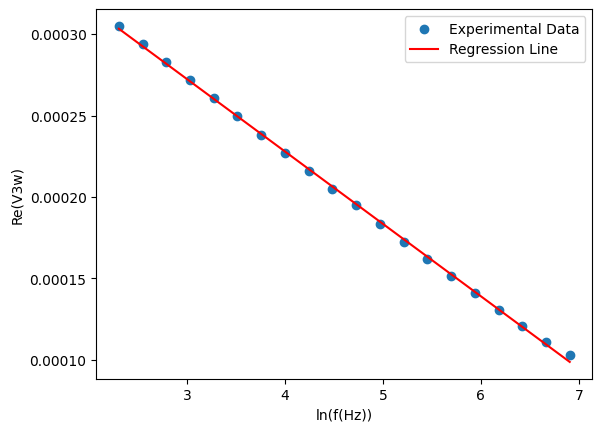

In [55]:
dVdf_mess=CryoTOCS.fit_dVdf(lnf,v3w)

In [56]:
dVdf_mess

### Thermal conductivity der Probe Berechnung

#### Korrelationsgleichung fuer die Messung

In [57]:
# Define variables
dRdT = symbols('dR/dT')
dVdf= symbols('dV3w/dlnf')
dR,dT,L,lambda_sample,lambda_sub,f,P,I = symbols('dR dT L lambda_sample, lambda_sub f P I')

In [58]:
equation_lambdaSample= Eq( (-P*I*dRdT/(4*pi*L))*(dVdf)**(-1)-lambda_sub-lambda_sample,0)

In [59]:
display(equation_lambdaSample)

In [60]:
P_mean= np.mean(P_mess)
I_mean= np.mean(I_mess)
print(P_mean)
print(I_mean)
print(lambdaSubstrate_mess)
print(dRdT_mess)

0.0010040000000000001
0.005363299999999999
3.0039
0.4711822750888865


In [61]:
substituted_eqLambdaSample = equation_lambdaSample.subs({dRdT:dRdT_mess,P: P_mean, I:I_mean, lambda_sub:lambdaSubstrate_mess,dVdf:dVdf_mess, L:L_mess})

In [62]:
substituted_eqLambdaSample

In [63]:
solSample = solve(substituted_eqLambdaSample, lambda_sample)

In [64]:
lambdaSample_mess=float(solSample[0])
lambdaSample_mess

## Messung Thermal conductivity Si

### Import data

In [80]:
path_sample='test\Messung061224\Si2.txt'

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\rinc\AppData\Local\Temp\ipykernel_22144\48910642.py:1: SyntaxWarning: invalid escape sequence '\M'
  path_sample='test\Messung061224\Si2.txt'


In [81]:
df_sample=CryoTOCS.import_Data(path_sample)
df_sample.head()

,Frequency,Re(1ω),Im(1ω),Re(3ω),Im(3ω),Phase(1ω),Phase(3ω),Vref,Current,Re(ΔT),Δ[Re(ΔT)],Im(ΔT),Δ[Im(ΔT)],Power,Temperature
0,10.000,0.187328134990776,-0.000000000000008,0.000305479241778,-0.000072301848385,-0.000000000002307,-13.315917740883085,0.053616,0.005362,0.939509,0.000000,-0.222366,0.010075,0.001004,23.53
1,12.743,0.187321609324799,0.000000000000000,0.000294124945368,-0.000071982511330,0.000000000000054,-13.751947313784402,0.053615,0.005362,0.904594,0.000000,-0.221385,0.010030,0.001004,23.52
2,16.238,0.187313334624629,0.000000000000002,0.000283089967804,-0.000072023187015,0.000000000000707,-14.274237969830605,0.053616,0.005362,0.870642,0.000000,-0.221507,0.010036,0.001004,23.51
3,20.691,0.187304145413308,0.000000000000005,0.000271910686126,-0.000071641859059,0.000000000001647,-14.760591208303117,0.053618,0.005362,0.836238,0.000000,-0.220328,0.009983,0.001004,23.49
4,26.367,0.187296660965373,0.000000000000003,0.000260670997890,-0.000071813837698,0.000000000000871,-15.402672722911191,0.053619,0.005362,0.801655,0.000000,-0.220853,0.010006,0.001004,23.47


### Parameters fuer die Berechnung

In [82]:
# Geometrie und Bedingungen
T_ref=23                 # Room temperature
print(dRdT_mess)

# Slope dRe(V3w)/dlnf Berechnung
v3w = df_sample['Re(3ω)'].values
f   = df_sample['Frequency'].values
v3w = v3w.astype(float)
f   = f.astype(float)

## Thermal conductivity Berechnung
P_mess = df_sample['Power'].values
P_mess = P_mess.astype(float)

I_mess = df_sample['Current'].values
I_mess = I_mess.astype(float)

0.4711822750888865


In [83]:
lambdaSubstrate_mess=CryoTOCS.lambdaSubstrate(T_ref)
lambdaSubstrate_mess

### Slope dRe(V3w)/dln(f)

In [84]:
lnf=np.log(f)
print(v3w)
print(f)
print(lnf)

[0.00030548 0.00029412 0.00028309 0.00027191 0.00026067 0.00024973
 0.00023851 0.00022747 0.00021644 0.00020531 0.00019428 0.00018241
 0.00017278 0.00016193 0.00015137 0.00014103 0.00013053 0.00012054
 0.00011059 0.00010247]
[  10.      12.743   16.238   20.691   26.367   33.598   42.813   54.556
   69.519   88.587  112.884  143.845  183.298  233.572  297.635  379.269
  483.293  615.848  784.76  1000.   ]
[2.30258509 2.5449821  2.78735417 3.02969882 3.27211323 3.51446654
 3.75684179 3.9992277  4.2416001  4.48398512 4.72636074 4.96873633
 5.21111324 5.45349038 5.6958679  5.93824572 6.18062309 6.42300018
 6.66537794 6.90775528]


Slope: -4.459988229619528e-05, Intercept: 0.00040642346171987067


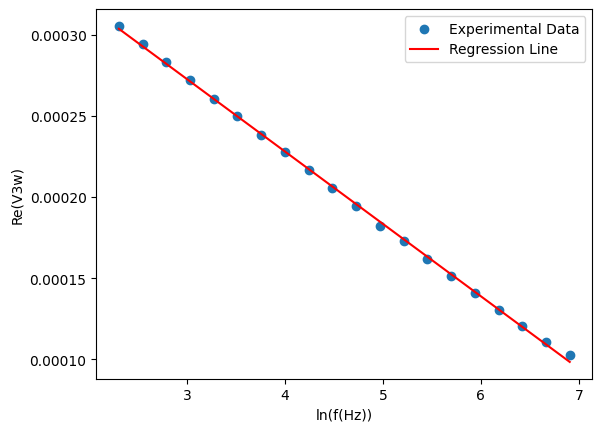

In [85]:
dVdf_mess=CryoTOCS.fit_dVdf(lnf,v3w)

In [86]:
dVdf_mess

### Thermal conductivity der Probe Berechnung

#### Korrelationsgleichung fuer die Messung

In [87]:
# Define variables
dRdT = symbols('dR/dT')
dVdf= symbols('dV3w/dlnf')
dR,dT,L,lambda_sample,lambda_sub,f,P,I = symbols('dR dT L lambda_sample, lambda_sub f P I')

In [88]:
equation_lambdaSample= Eq( (-P*I*dRdT/(4*pi*L))*(dVdf)**(-1)-lambda_sub-lambda_sample,0)

In [89]:
display(equation_lambdaSample)

In [90]:
P_mean= np.mean(P_mess)
I_mean= np.mean(I_mess)
print(P_mean)
print(I_mean)
print(lambdaSubstrate_mess)
print(dRdT_mess)

0.0010040000000000001
0.005362999999999998
3.0039
0.4711822750888865


In [91]:
substituted_eqLambdaSample = equation_lambdaSample.subs({dRdT:dRdT_mess,P: P_mean, I:I_mean, lambda_sub:lambdaSubstrate_mess,dVdf:dVdf_mess, L:L_mess})

In [92]:
substituted_eqLambdaSample

In [93]:
solSample = solve(substituted_eqLambdaSample, lambda_sample)

In [94]:
lambdaSample_mess=float(solSample[0])
lambdaSample_mess